In [2]:
# install 
# !apt update && apt install -y ffmpeg libsm6 libxext6

In [3]:
#Importing necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px

plt.rcParams['figure.figsize'] = (10, 7)

import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0,15.0)
objectnessThreshold = 0.5 # Objectness threshold
matplotlib.rcParams['image.cmap'] = 'gray'

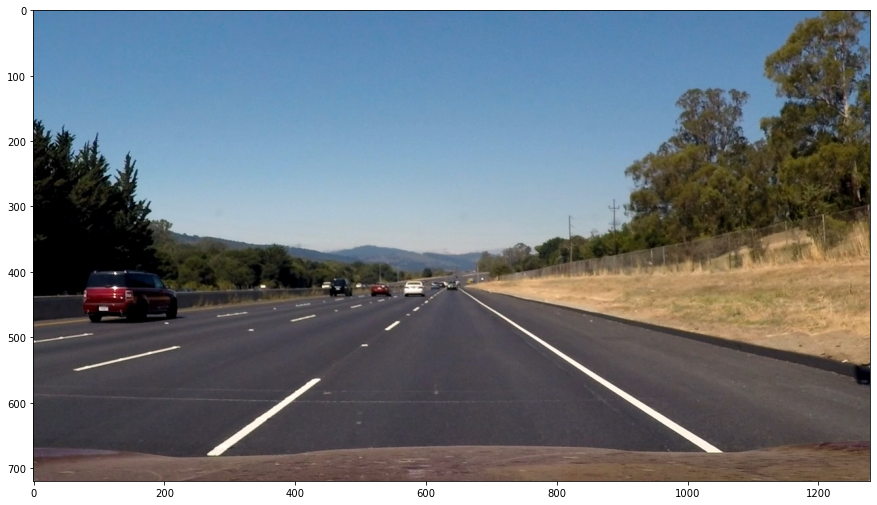

In [4]:
#Loading test image
image = cv2.imread("./test_images/straight_lines2.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image);

In [5]:
#Defining function to reduce noise and detect edges
def canny_edge_detector(image): 
      
    # Convert the image color to grayscale 
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  
      
    # Reduce noise from the image 
    blur = cv2.GaussianBlur(gray_image, (5, 5), 0)  
    canny = cv2.Canny(blur, 100, 150) 
    return canny 

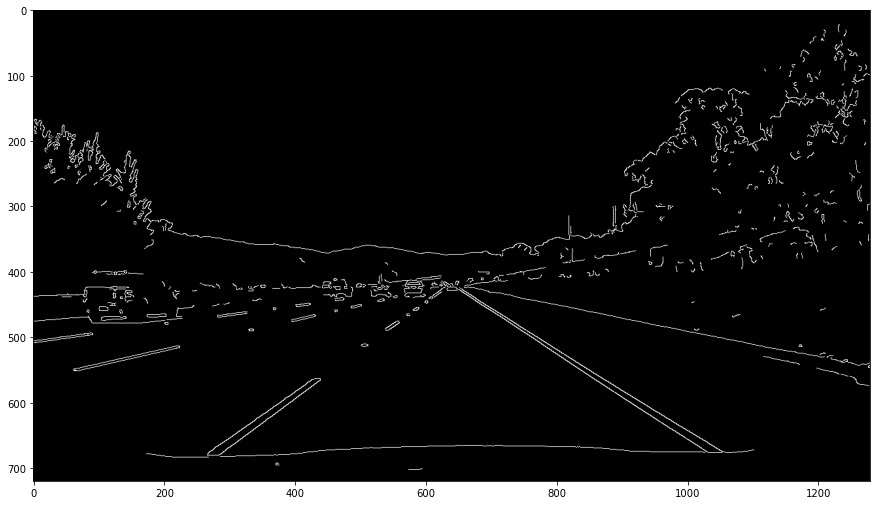

In [6]:
#Showing image with detected edges
canny_image = canny_edge_detector(image)
plt.imshow(canny_image);

In [7]:
# Specifying region of interest with a polygon on the image 
def region_of_interest(image): 
    height = image.shape[0] 
    width = image.shape[1]
    polygons = np.array([ 
        [(int(width*0.1), int(height*0.92)),
        (int(width/2), int(height*0.6)),
        (int(width*0.9), int(height*0.92))]
        ]) 
    
    mask = np.zeros_like(image) 
      
    # Fill poly-function deals with multiple polygon 
    cv2.fillPoly(mask, polygons, 255)  
      
    # Bitwise operation between canny image and mask image 
    masked_image = cv2.bitwise_and(image, mask)  
    return masked_image

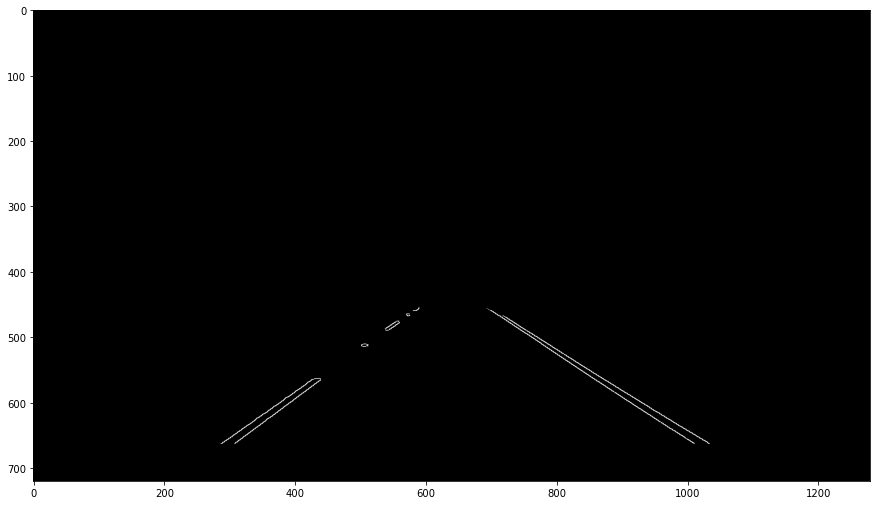

In [8]:
cropped_image = region_of_interest(canny_image)
plt.imshow(cropped_image);

In [9]:
def create_coordinates(image, line_parameters): 
    try:
        slope, intercept = line_parameters
    except TypeError:
        slope, intercept = 0.001, 0
    #slope, intercept = line_parameters 
    y1 = image.shape[0] 
    y2 = int(y1 * (3 / 5)) 
    x1 = int((y1 - intercept) / slope) 
    x2 = int((y2 - intercept) / slope) 
    return np.array([x1, y1, x2, y2])

In [10]:
def average_slope_intercept(image, lines): 
    left_fit = [] 
    right_fit = []
    if lines is not None:
        for line in lines: 
            x1, y1, x2, y2 = line.reshape(4) 

            # It will fit the polynomial and the intercept and slope 
            parameters = np.polyfit((x1, x2), (y1, y2), 1)  
            slope = parameters[0] 
            intercept = parameters[1] 
            if slope < 0: 
                left_fit.append((slope, intercept)) 
            else: 
                right_fit.append((slope, intercept)) 

    left_fit_average = np.average(left_fit, axis = 0) 
    right_fit_average = np.average(right_fit, axis = 0) 
    left_line = create_coordinates(image, left_fit_average) 
    right_line = create_coordinates(image, right_fit_average) 
    return np.array([left_line, right_line]) 

In [11]:
def display_lines(image, lines): 
    line_image = np.zeros_like(image) 
    if lines is not None:
        for line in lines: 
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10) 
    return line_image 

In [12]:
averaged_lines = average_slope_intercept(image, lines)

line_image = display_lines(image, averaged_lines)

combo_image = cv2.addWeighted(image, 0.8, line_image, 1, 1)  

NameError: name 'lines' is not defined

In [ ]:
fig = plt.figure(figsize=(20, 13)) 
rows = 1
columns = 3
  
# Adds a subplot at the 1st position 
fig.add_subplot(rows, columns, 1) 
plt.imshow(combo_image) 
plt.axis('off') 
plt.title("combined images") 

# Adds a subplot at the 1st position 
fig.add_subplot(rows, columns, 2) 
plt.imshow(line_image) 
plt.axis('off') 
plt.title("detected lines") 
  
# Adds a subplot at the 2nd position 
fig.add_subplot(rows, columns, 3) 
plt.imshow(image) 
plt.axis('off') 
plt.title("origial image"); 

In [13]:
cap = cv2.VideoCapture("./videos/challenge_video.mp4")  
while(cap.isOpened()): 
    _, frame = cap.read() 
    if frame is not None:
        #cv2.imshow("original", frame)
        canny_image = canny_edge_detector(frame) 
        cropped_image = region_of_interest(canny_image) 
        cv2.imshow("cropped", cropped_image)
        lines = cv2.HoughLinesP(
                    image = cropped_image,
                    rho = 2,
                    theta = np.pi / 180,
                    threshold = 45, # 100
                    lines = np.array([]),
                    minLineLength = 40,  
                    maxLineGap = 100)  

        #averaged_lines = average_slope_intercept(frame, lines)
        line_image = display_lines(image, lines)
        combo_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)  
        cv2.imshow("results", combo_image) 

        # When the below two will be true and will press the 'q' on 
        # our keyboard, we will break out from the loop 

        # # wait 0 will wait for infinitely between each frames.  
        # 1ms will wait for the specified time only between each frames 
        if cv2.waitKey(30) & 0xFF == ord('q'):       
            break
    else:
        break

# close the video file 
cap.release()  
  
# destroy all the windows that is currently on 
cv2.destroyAllWindows()  
cv2.waitKey(1)

-1

In [37]:
# Initialize the parameters
confThreshold = 0.1       # Confidence threshold
nmsThreshold = 0.4        # Non-maximum suppression threshold
inpWidth = 416            # Width of network's input image
inpHeight = 416           # Height of network's input image-preprocessing.ipynb

MODEL_PATH = '/Users/tobiasschulz/Documents/GitHub/road-lane-detection/coco/'
# Load names of classes
classesFile = MODEL_PATH + "coco.names"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = MODEL_PATH + "yolov3.cfg"
modelWeights = MODEL_PATH + "yolov3.weights"

net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)

In [38]:
# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    classIds = []
    confidences = []
    boxes = []
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            if detection[4] > objectnessThreshold :
                scores = detection[5:]
                classId = np.argmax(scores)
                confidence = scores[classId]
                if confidence > confThreshold:
                    center_x = int(detection[0] * frameWidth)
                    center_y = int(detection[1] * frameHeight)
                    width = int(detection[2] * frameWidth)
                    height = int(detection[3] * frameHeight)
                    left = int(center_x - width / 2)
                    top = int(center_y - height / 2)
                    classIds.append(classId)
                    confidences.append(float(confidence))
                    boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(classIds[i], confidences[i], left, top, left + width, top + height)

In [39]:
# Draw the predicted bounding box
def drawPred(classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3)
    
    label = '%.2f' % conf
        
    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv2.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

In [42]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [47]:
cap = cv2.VideoCapture("./videos/challenge_video.mp4")  
while(cap.isOpened()): 
    _, frame = cap.read() 
    if frame is not None:
        #cv2.imshow("original", frame)
        canny_image = canny_edge_detector(frame) 
        cropped_image = region_of_interest(canny_image) 
        cv2.imshow("cropped", cropped_image)
        lines = cv2.HoughLinesP(
                    image = cropped_image,
                    rho = 2,
                    theta = np.pi / 180,
                    threshold = 45, # 100
                    lines = np.array([]),
                    minLineLength = 40,  
                    maxLineGap = 100)  

        #averaged_lines = average_slope_intercept(frame, lines)
        line_image = display_lines(image, lines)
        combo_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)  

        # Create a 4D blob from a frame.
        blob = cv2.dnn.blobFromImage(combo_image, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

        # Sets the input to the network
        net.setInput(blob)

        # Runs the forward pass to get output of the output layers
        outs = net.forward(getOutputsNames(net))
        #outs = net.forward()

        # Remove the bounding boxes with low confidence
        postprocess(combo_image, outs)

        # Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
        t, _ = net.getPerfProfile()
        label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
        cv2.putText(combo_image, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255))
        
        cv2.imshow("results", combo_image[...,::-1]) 

        # When the below two will be true and will press the 'q' on 
        # our keyboard, we will break out from the loop 

        # # wait 0 will wait for infinitely between each frames.  
        # 1ms will wait for the specified time only between each frames 
        if cv2.waitKey(30) & 0xFF == ord('q'):       
            break
    else:
        break

# close the video file 
cap.release()  
  
# destroy all the windows that is currently on 
cv2.destroyAllWindows()  
cv2.waitKey(1)

-1